### Problem Statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Importing the dependencies

In [5]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization, Rescaling
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

### Unzip the datafile

In [2]:
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

### Defining the path for train and test images

In [6]:
root_path = '/content/Skin cancer ISIC The International Skin Imaging Collaboration'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

 ### Image Count

In [7]:
print(f"Number of Images in Train Directory: {len(list(data_dir_train.glob('*/*.jpg')))}")
print(f"Number of Images in Test Directory: {len(list(data_dir_test.glob('*/*.jpg')))}")

Number of Images in Train Directory: 2239
Number of Images in Test Directory: 118


### Load using keras.preprocessing

- Let's load these images off disk using the helpful image_dataset_from_directory utility.


### Create a dataset

- Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

- Use 80% of the images for training, and 20% for validation.

In [9]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#### Data Visualization

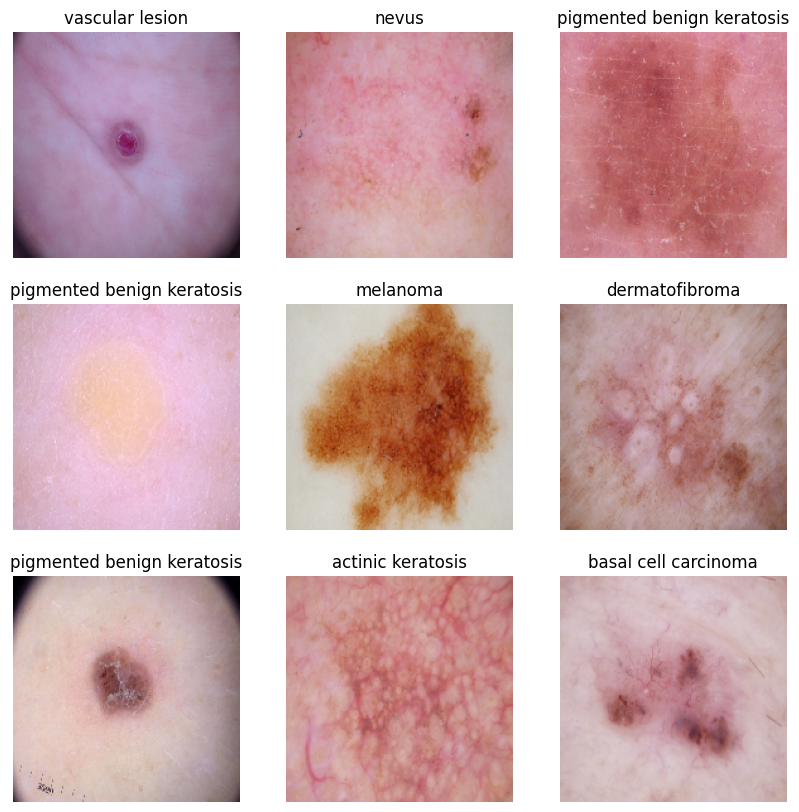

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

- The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

### Determine number of images in each class

In [13]:
def number_of_images(directory):
  # count number of image in each classes
  count= []
  for path in pathlib.Path(directory).iterdir():
    if path.is_dir():
      count.append(len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]))
  # name of the classes
  sub_directory = [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]
  # return dataframe with image count and class.
  return pd.DataFrame(list(zip(sub_directory,count)),columns =['Image Class', 'Number of Images']).sort_values(by='Number of Images', ascending=False).reset_index(drop=True)

number_of_images(data_dir_train)

,Image Class,Number of Images
0,pigmented benign keratosis,462
1,melanoma,438
2,basal cell carcinoma,376
3,nevus,357
4,squamous cell carcinoma,181
5,vascular lesion,139
6,actinic keratosis,114
7,dermatofibroma,95
8,seborrheic keratosis,77


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### CNN model to detect 9 classes present in the dataset.

- Used ```tensorflow.keras.layers.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [37]:
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu',padding='Same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu',padding='Same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu',padding='Same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu',padding='Same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 45, 45, 128)      

### Inspect Model Summary

In [38]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 45, 45, 128)      

### Visualizing the model structure

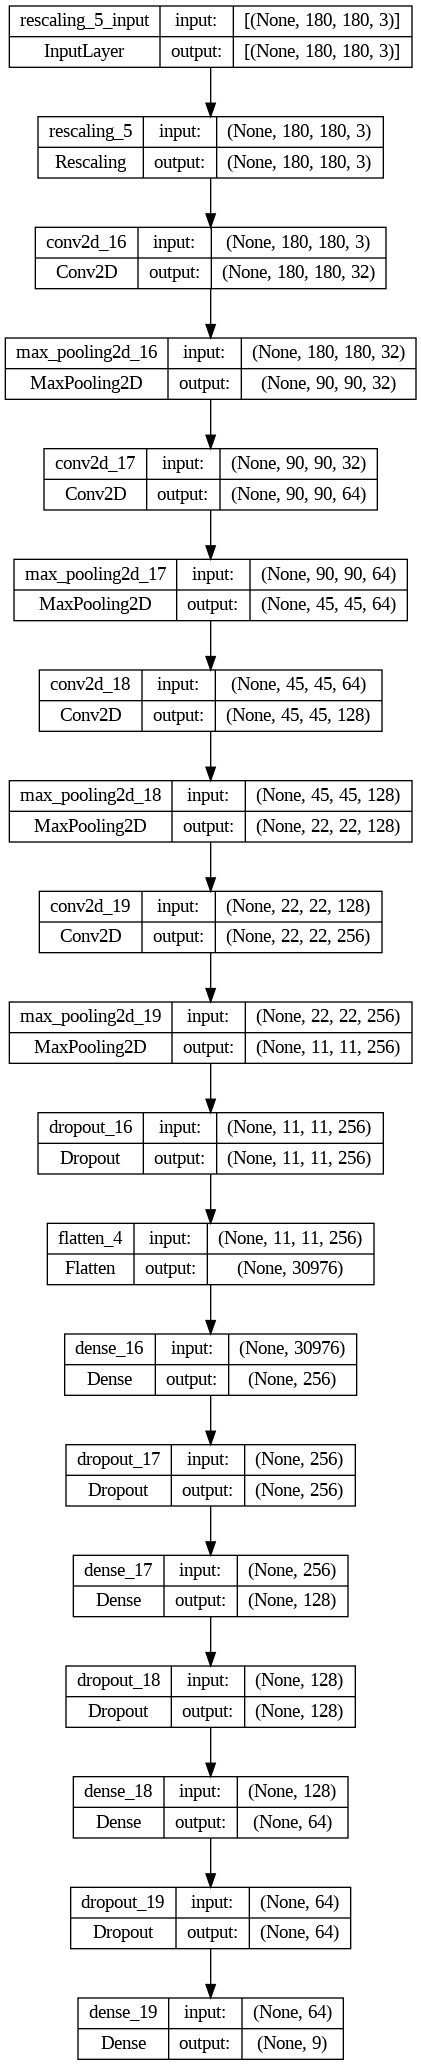

In [39]:
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

 ### Compile the model
- Chosen an appropirate optimiser and loss function for model training

  1) **Optimizer**: SGD is simple but effective, while Adam may be more computationally intensive but often converge faster. So, given the time constraints, chose **`Adam`** over SGD

  2) __Loss__: Sparse categorical cross-entropy loss function works by first converting the true labels into one-hot encoded vectors internally and then applying the regular categorical cross-entropy loss calculation

In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Reduce learning rate when val_accuracy has stopped improving.
- This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced. Factor by which the learning rate will be reduced. `new_lr = lr * factor`

In [41]:
lr_ctrl = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=1e-7)

#### ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

In [42]:
checkpoint = ModelCheckpoint("model.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

#### Stop training when a monitored metric has stopped improving.

In [43]:
early_stop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

### Train the Model

In [44]:
epochs = 40
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[lr_ctrl, checkpoint, early_stop]
)

Epoch 1/40
56/56 [==============================] - ETA: 0s - loss: 2.1410 - accuracy: 0.1886
Epoch 1: val_accuracy improved from -inf to 0.19239, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/56 [==============================] - 7s 77ms/step - loss: 2.1410 - accuracy: 0.1886 - val_loss: 2.0546 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 2/40
56/56 [==============================] - ETA: 0s - loss: 2.0522 - accuracy: 0.1858
Epoch 2: val_accuracy improved from 0.19239 to 0.20582, saving model to model.h5
56/56 [==============================] - 5s 87ms/step - loss: 2.0522 - accuracy: 0.1858 - val_loss: 2.0163 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 3/40
56/56 [==============================] - ETA: 0s - loss: 2.0326 - accuracy: 0.2003
Epoch 3: val_accuracy did not improve from 0.20582
56/56 [==============================] - 4s 68ms/step - loss: 2.0326 - accuracy: 0.2003 - val_loss: 1.9855 - val_accuracy: 0.1946 - lr: 0.0010
Epoch 4/40
56/56 [==============================] - ETA: 0s - loss: 2.0534 - accuracy: 0.1892
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 4: val_accuracy did not improve from 0.20582
56/56 [======================

### Visualizing Training Results

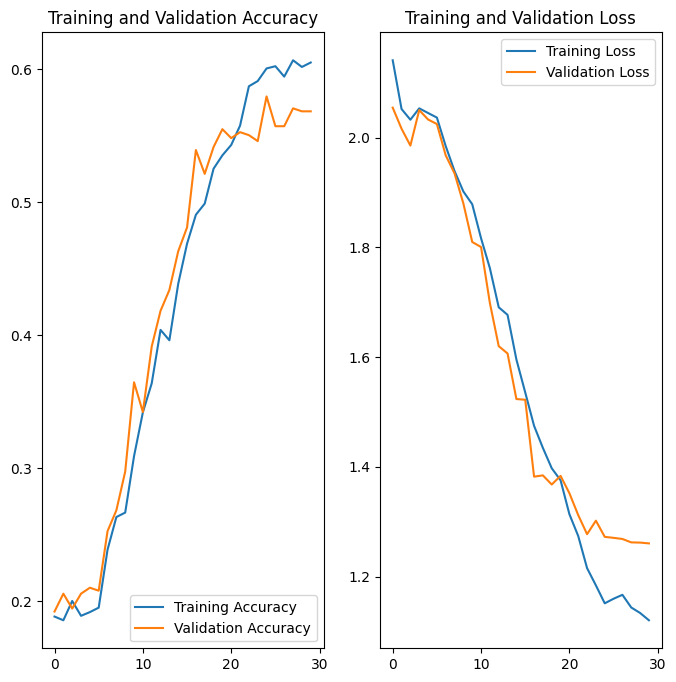

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = np.arange(early_stop.stopped_epoch+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Interpretation :***

---



From 26th epoch onwards, the model started to gain a little higher variance which is evident from the dissimilarity between train and validation losses, despite having the dropout layers in the model architecture. Recommendation is to reduce the learning rate a little more at few early epochs to prevent it from overfitting the train set at higher epochs, if we keep its architecture intact.

In [46]:
from keras.models import load_model

if pathlib.Path('/content/model.h5').is_file():
  # if model is available at the current runtime
  model_1 = load_model('model.h5')
  print('INFO: Temporary stored "model.h5" has been loaded successfully.')
  print('WARNING: Prevent losing the temporary "model.h5" file. You must download and save the file at "gdrive/MyDrive", so it can be loaded later from this location in the event of unintended runtime disconnection !!')
elif pathlib.Path('/content/gdrive/MyDrive/model.h5').is_file():
  # load the serialized weights from
  model_1 = load_model(pathlib.Path('/content/gdrive/MyDrive/model.h5'))
  print('INFO: "gdrive/MyDrive/model.h5" file has been loaded successfully.')
else:
  raise Exception('FileNotFoundError: Your last runtime was disconnected and hence the current runtime could not retrieve the previously created temporary HDF5 model file. Maybe you have missed to download/save the previously generated "model.h5" file at your directory "/gdrive/MyDrive" to reuse it in the event of unintended runtime diconnection !!')
train_loss, train_accuracy = model_1.evaluate(train_ds, verbose=1,)
validation_loss, validation_accuracy = model_1.evaluate(val_ds, verbose=1)

print('Train Accuracy: ', train_accuracy)
print('Validation Accuracy: ',validation_accuracy)
print('Train Loss: ',train_loss)
print('Validation Loss', validation_loss)

INFO: Temporary stored "model.h5" has been loaded successfully.
14/14 [==============================] - 0s 16ms/step - loss: 1.2723 - accuracy: 0.5794
Train Accuracy:  0.6244419813156128
Validation Accuracy:  0.5794183611869812
Train Loss:  1.0491983890533447
Validation Loss 1.272296667098999


 ***About Saved Weights >> `model.h5` :***

 ---

 1. The model built or saved is significantly better than a random guessor as the train accuracy is 62%.

 2. Though both the train and validation accuracies are slightly different but they are considerably very low. Hence, the estimated model seemed to underfit the train set.

 3. We will try with data augumentation strategy with flip, rotate, contrast, brightness, zoom, saturation etc to assess if it improves the overall model performance

### Using Data Augmentation Utilities

In [15]:
data_augmentation = tf.keras.Sequential(
    [layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width,3)),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.1),
     layers.RandomContrast(0.1),
    #  layers.RandomBrightness(0.1)
    ]
)

 ### Visualizing data augmentation with nine examples for a single training image.

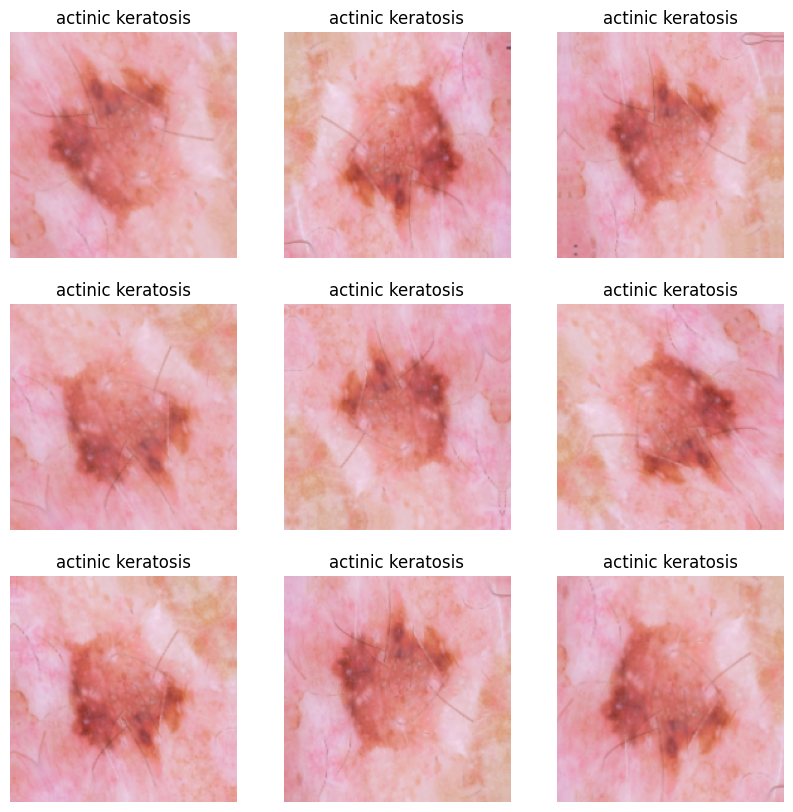

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_images = data_augmentation(images)
    plt.imshow(augmented_images[2].numpy().astype("uint8"))
    plt.title(class_names[labels[2]])
    plt.axis("off")
  break

### Create the model with data augmentation layer.

In [29]:
model_augmen = Sequential()
model_augmen.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model_augmen.add(data_augmentation)
model_augmen.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu',padding='Same'))
model_augmen.add(layers.MaxPool2D(pool_size=(2,2)))
model_augmen.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu',padding='Same'))
model_augmen.add(layers.MaxPool2D(pool_size=(2,2)))
model_augmen.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu',padding='Same'))
model_augmen.add(layers.MaxPool2D(pool_size=(2,2)))
model_augmen.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu',padding='Same'))
model_augmen.add(layers.MaxPool2D(pool_size=(2,2)))
model_augmen.add(layers.Dropout(0.5))
model_augmen.add(layers.Flatten())
model_augmen.add(layers.Dense(256,activation='relu'))
model_augmen.add(layers.Dropout(0.25))
model_augmen.add(layers.Dense(128,activation='relu'))
model_augmen.add(layers.Dropout(0.25))
model_augmen.add(layers.Dense(64,activation='relu'))
model_augmen.add(layers.Dropout(0.25))
model_augmen.add(layers.Dense(len(class_names),activation='softmax'))

model_augmen.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                 

### Visualizing the `model_augmen` architecture

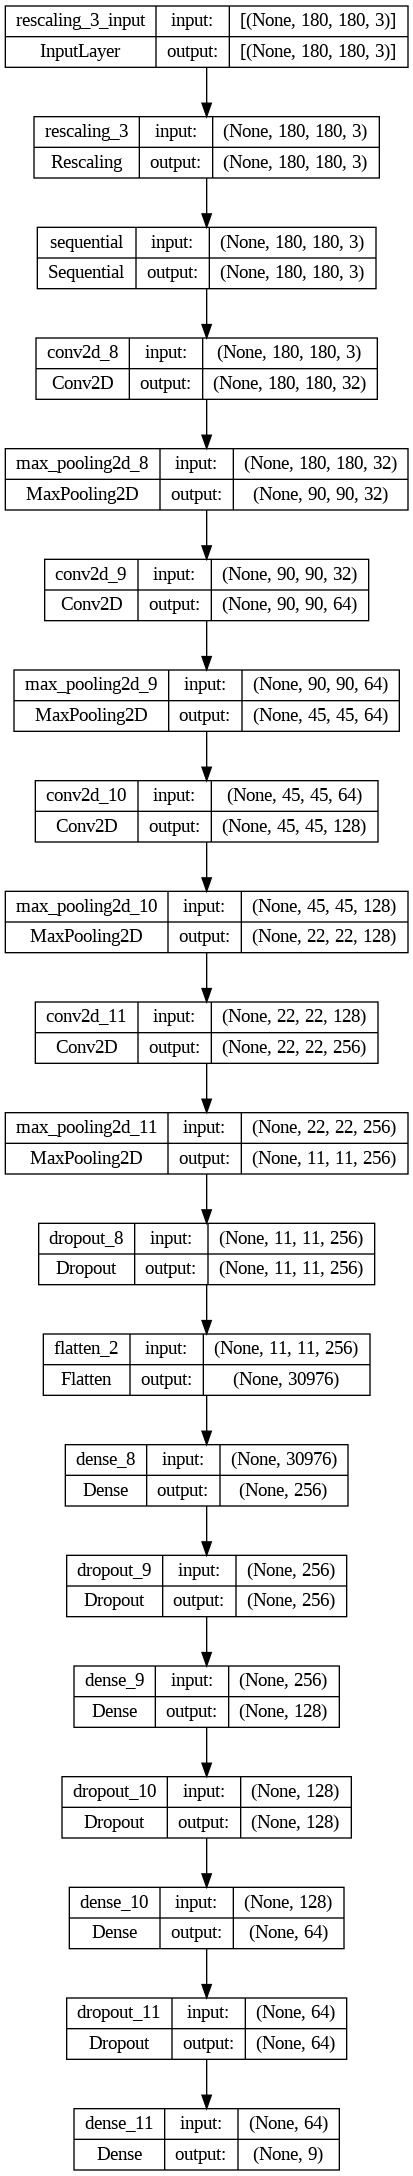

In [30]:
plot_model(model_augmen, to_file='model_augmen_structure.png', show_shapes=True, show_layer_names=True)

### Compiling `model_augmen`

  - Refer a previous cell of this notebook that explains the reason of the optimizer choice and the loss funtion

In [31]:
model_augmen.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     metrics=['accuracy']
)

### Setup callbacks for `model_augmen`

  - Refer the earlier cells of this notebook for descriptions on these setups

In [32]:
lr_ctrl_augmen = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=1e-7)
checkpoint_augmen = ModelCheckpoint("model_augmen.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
early_stop_augmen = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

### Training `model_augmen`

In [33]:
epochs = 40
history = model_augmen.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[lr_ctrl_augmen, checkpoint_augmen, early_stop_augmen]
    # callbacks=[checkpoint_augmen, early_stop_augmen]
)

Epoch 1/40
56/56 [==============================] - ETA: 0s - loss: 2.1266 - accuracy: 0.2042
Epoch 1: val_accuracy improved from -inf to 0.23043, saving model to model_augmen.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/56 [==============================] - 8s 81ms/step - loss: 2.1266 - accuracy: 0.2042 - val_loss: 2.0341 - val_accuracy: 0.2304 - lr: 0.0010
Epoch 2/40
56/56 [==============================] - ETA: 0s - loss: 1.9997 - accuracy: 0.2310
Epoch 2: val_accuracy improved from 0.23043 to 0.28859, saving model to model_augmen.h5
56/56 [==============================] - 4s 76ms/step - loss: 1.9997 - accuracy: 0.2310 - val_loss: 1.8931 - val_accuracy: 0.2886 - lr: 0.0010
Epoch 3/40
56/56 [==============================] - ETA: 0s - loss: 1.8943 - accuracy: 0.2812
Epoch 3: val_accuracy did not improve from 0.28859
56/56 [==============================] - 4s 70ms/step - loss: 1.8943 - accuracy: 0.2812 - val_loss: 1.9931 - val_accuracy: 0.2640 - lr: 0.0010
Epoch 4/40
56/56 [==============================] - ETA: 0s - loss: 1.8625 - accuracy: 0.2980
Epoch 4: val_accuracy improved from 0.28859 to 0.38926, saving model to model_augmen.h5
56/56 [==============================] - 4s 78ms/step - loss: 

### Visualizing the training results (`model_augmen`)

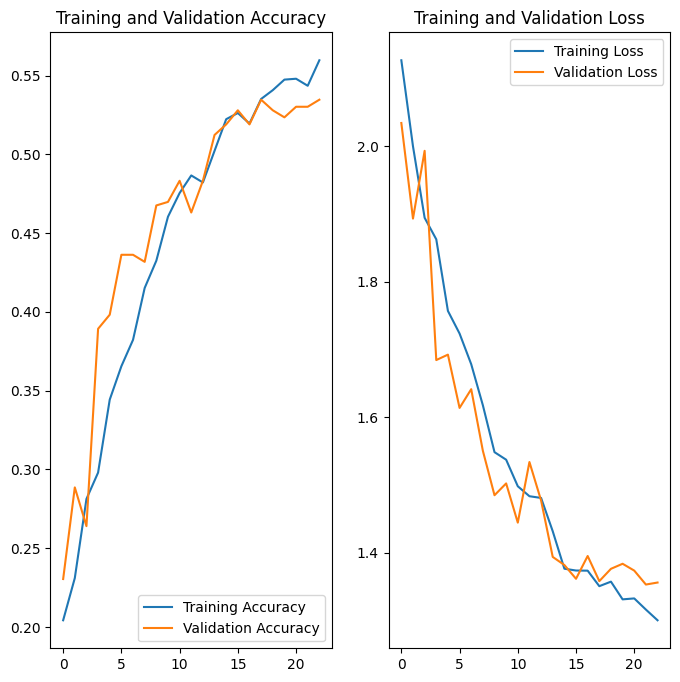

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = np.arange(early_stop_augmen.stopped_epoch+1)
# epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Interpretation :***

---

 1. We increased the diversity among the individual training images when we added the data augmentation layer in the model architecture. This prevented it from detecting any prominent patterns in those images over subsequent epochs to better separate them between classes. Hence the training accuracy is significantly lower, underfitting the images belonging to the majority class. Might be the need is to train it for much larger number of epochs before invoking the early stopping scheme (monitoring the improvement in the validation accuracy)

 2. We observed fluctuations in the validation loss with reduction in the training loss over subsequent epochs, as the model seemed to jump over the minima frequently as it experienced much higher variability with the augmented training images. Recommendation is to start with a much lower learning rate or reduce the learning rate at few earlier epochs to ensure smooth and slow convergence, with training the underlying algorithm over large number of epochs to achieve requisite performance

In [50]:
from keras.models import load_model

if pathlib.Path('/content/model_augmen.h5').is_file():
  # if model is available at the current runtime
  model_1 = load_model('model_augmen.h5')
  print('INFO: Temporary stored "model_augmen.h5" has been loaded successfully.')
  print('WARNING: Prevent losing the temporary "model_augmen.h5" file. You must download and save the file at "gdrive/MyDrive", so it can be loaded later from this location in the event of unintended runtime disconnection !!')
elif pathlib.Path('/content/gdrive/MyDrive/model_augmen.h5').is_file():
  # load the serialized weights from
  model_1 = load_model(pathlib.Path('/content/gdrive/MyDrive/model_augmen.h5'))
  print('INFO: "gdrive/MyDrive/model_augmen.h5" file has been loaded successfully.')
else:
  raise Exception('FileNotFoundError: Your last runtime was disconnected and hence the current runtime could not retrieve the previously created temporary HDF5 model file. Maybe you have missed to download/save the previously generated "model_augmen.h5" file at your directory "/gdrive/MyDrive" to reuse it in the event of unintended runtime diconnection !!')
train_loss, train_accuracy = model_1.evaluate(train_ds, verbose=1,)
validation_loss, validation_accuracy = model_1.evaluate(val_ds, verbose=1)

print('Train Accuracy: ', train_accuracy)
print('Validation Accuracy: ',validation_accuracy)
print('Train Loss: ',train_loss)
print('Validation Loss', validation_loss)

INFO: Temporary stored "model_augmen.h5" has been loaded successfully.
14/14 [==============================] - 0s 15ms/step - loss: 1.3583 - accuracy: 0.5347
Train Accuracy:  0.5563616156578064
Validation Accuracy:  0.5346755981445312
Train Loss:  1.2533401250839233
Validation Loss 1.3582593202590942


 ***About Saved Weights >> `model_augmen.h5` :***

 ---

 1. The model built or saved is not significantly better than a random guessor as the train accuracy is just 56%.

 2. Though both the train and validation accuracies are merely the same but they are considerably very low. Hence, the estimated model seemed to underfit the train set.

### Distribution of classes in the training dataset.

---

#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [51]:
number_of_images(data_dir_train)

,Image Class,Number of Images
0,pigmented benign keratosis,462
1,melanoma,438
2,basal cell carcinoma,376
3,nevus,357
4,squamous cell carcinoma,181
5,vascular lesion,139
6,actinic keratosis,114
7,dermatofibroma,95
8,seborrheic keratosis,77


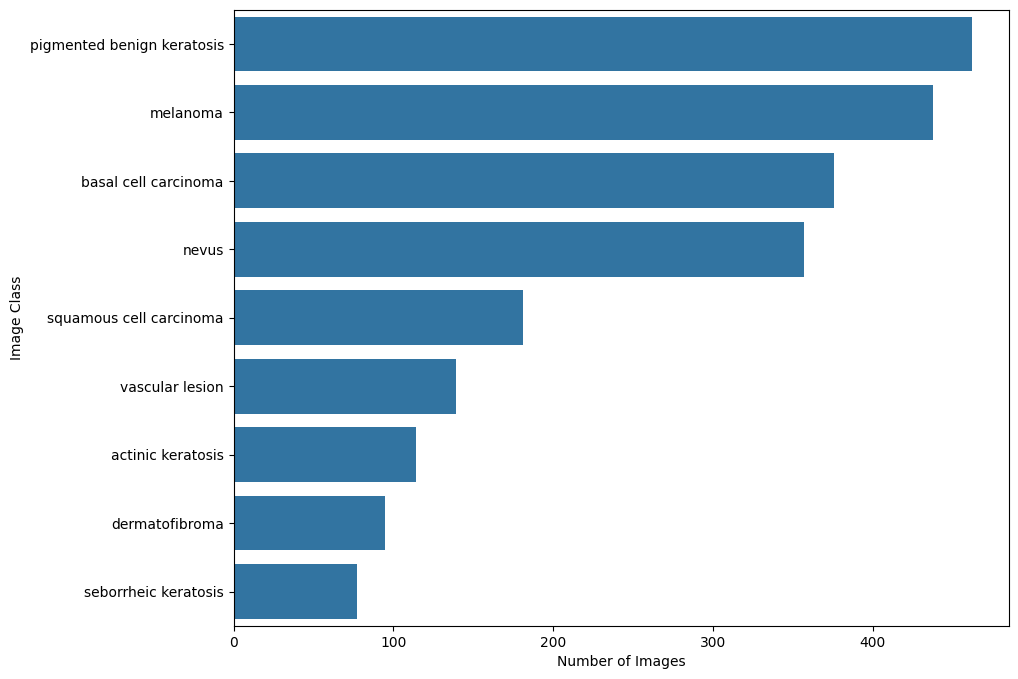

In [52]:
#Visualize the Number of images in each class.
plt.figure(figsize=(10, 8))
sns.barplot(x="Number of Images", y="Image Class", data=number_of_images(data_dir_train))
plt.show()

**Which class has the least number of samples?**

---
seborrheic keratosis has 77 training examples

 **Which classes dominate the data in terms proportionate number of samples?**

 ---

 1. pigmented benign keratosis with 462 training images
 2. melanoma with 438 training images
 3. basal cell carcinoma with 376 training images
 4. nevus with 357 training images

### Rectify the class imbalance

 - Used a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [53]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [54]:
path_to_training_dataset = "/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x789A643937F0>: 100%|██████████| 500/500 [00:20<00:00, 23.82 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x789A64393EB0>: 100%|██████████| 500/500 [00:24<00:00, 20.43 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x789A64304070>: 100%|██████████| 500/500 [00:24<00:00, 20.76 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x789A5EF9F760>: 100%|██████████| 500/500 [01:24<00:00,  5.94 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x789A544F4E20>: 100%|██████████| 500/500 [01:20<00:00,  6.23 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x789A6423BA00>: 100%|██████████| 500/500 [00:15<00:00, 32.03 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x789AC01F24D0>: 100%|██████████| 500/500 [00:37<00:00, 13.20 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x789A5EEA2620>: 100%|██████████| 500/500 [00:15<00:00, 31.90 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x789A643D51B0>: 100%|██████████| 500/500 [00:14<00:00, 33.45 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [55]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [56]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000165.jpg_462f7118-c6d0-4c7e-9fbe-10c83c694a90.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010812.jpg_e908cde4-52d2-4ce5-b20b-fc5a788d5426.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010397.jpg_f6e4894f-0386-41c1-be25-5ca250b1b33f.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000304.jpg_72e3d2ae-f127-45a7-9984-f851ece73623.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010225.jpg_697824b7-a702-4fdd-9136-6b9a7ce181f6.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010364.jpg_725d9

In [57]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [58]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [59]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [60]:
df2['Label'].value_counts()

Label
melanoma                      500
seborrheic keratosis          500
dermatofibroma                500
pigmented benign keratosis    500
basal cell carcinoma          500
squamous cell carcinoma       500
vascular lesion               500
nevus                         500
actinic keratosis             500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Train a new model on the data created using Augmentor

In [61]:
batch_size = 32
img_height = 180
img_width = 180

### Creating the new training dataset

In [62]:
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = "training",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Creating the new validation dataset

In [63]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = "validation",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Create new model (including normalization)

In [64]:
model_augmentor = Sequential()
model_augmentor.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model_augmentor.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu',padding='Same'))
model_augmentor.add(layers.MaxPool2D(pool_size=(2,2)))
model_augmentor.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu',padding='Same'))
model_augmentor.add(layers.MaxPool2D(pool_size=(2,2)))
model_augmentor.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu',padding='Same'))
model_augmentor.add(layers.MaxPool2D(pool_size=(2,2)))
model_augmentor.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu',padding='Same'))
model_augmentor.add(layers.MaxPool2D(pool_size=(2,2)))
model_augmentor.add(layers.Dropout(0.5))
model_augmentor.add(layers.Flatten())
model_augmentor.add(layers.Dense(256,activation='relu'))
model_augmentor.add(layers.Dropout(0.25))
model_augmentor.add(layers.Dense(128,activation='relu'))
model_augmentor.add(layers.Dropout(0.25))
model_augmentor.add(layers.Dense(64,activation='relu'))
model_augmentor.add(layers.Dropout(0.25))
model_augmentor.add(layers.Dense(len(class_names),activation='softmax'))

model_augmentor.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 45, 45, 128)      

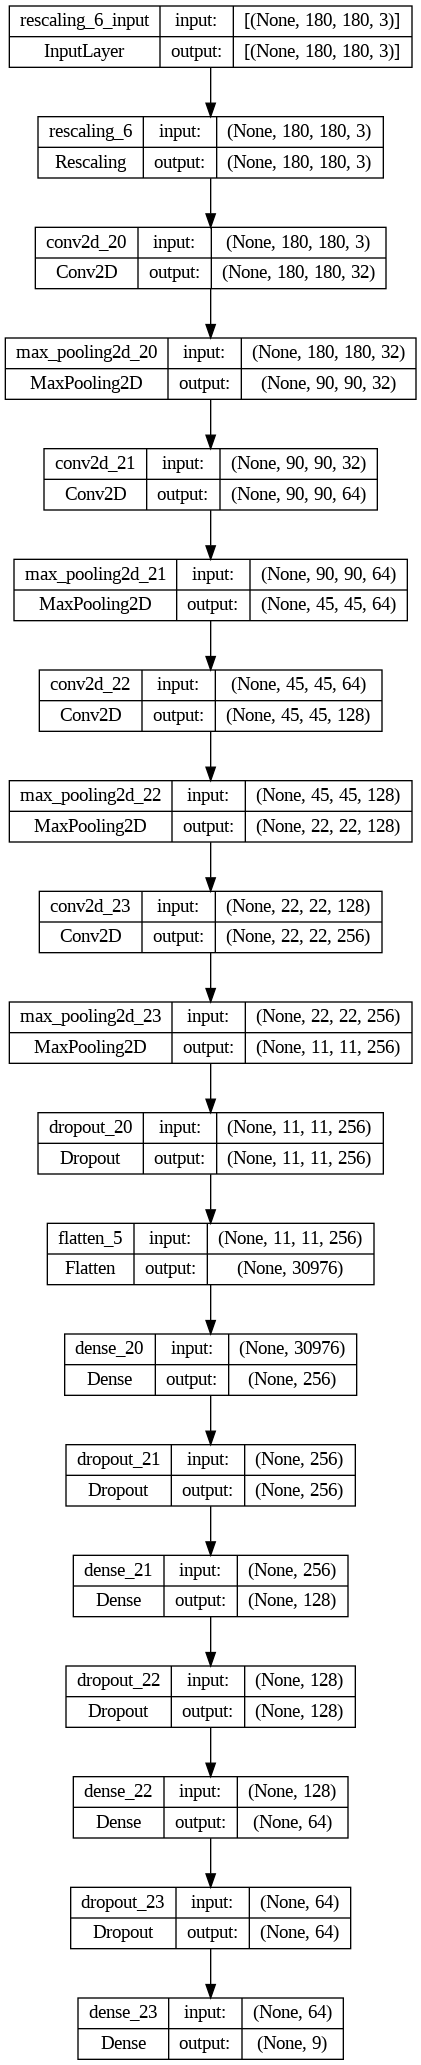

In [65]:
plot_model(model_augmentor, to_file='model_augmentor_structure.png', show_shapes=True, show_layer_names=True)

### Compiling `model_augmentor`

  - Refer a previous cell of this notebook that explains the reason of the optimizer choice and the loss funtion

In [66]:
model_augmentor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics=['accuracy']
)

### Setup callbacks for `model_augmentor`

  - Refer the earlier cells of this notebook for descriptions on these setups

In [67]:
lr_ctrl_augmentor = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=1e-7)
checkpoint_augmentor = ModelCheckpoint("model_augmentor.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
early_stop_augmentor = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

### Training `model_augmentor`

In [68]:
epochs = 50
history = model_augmentor.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[lr_ctrl_augmentor, checkpoint_augmentor, early_stop_augmentor]
)

Epoch 1/50
169/169 [==============================] - ETA: 0s - loss: 2.0983 - accuracy: 0.1779
Epoch 1: val_accuracy improved from -inf to 0.30735, saving model to model_augmentor.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


169/169 [==============================] - 44s 243ms/step - loss: 2.0983 - accuracy: 0.1779 - val_loss: 1.8764 - val_accuracy: 0.3073 - lr: 0.0010
Epoch 2/50
168/169 [============================>.] - ETA: 0s - loss: 1.7359 - accuracy: 0.3272
Epoch 2: val_accuracy improved from 0.30735 to 0.38827, saving model to model_augmentor.h5
169/169 [==============================] - 29s 166ms/step - loss: 1.7357 - accuracy: 0.3272 - val_loss: 1.5657 - val_accuracy: 0.3883 - lr: 0.0010
Epoch 3/50
168/169 [============================>.] - ETA: 0s - loss: 1.5909 - accuracy: 0.3880
Epoch 3: val_accuracy improved from 0.38827 to 0.45880, saving model to model_augmentor.h5
169/169 [==============================] - 29s 168ms/step - loss: 1.5907 - accuracy: 0.3880 - val_loss: 1.3367 - val_accuracy: 0.4588 - lr: 0.0010
Epoch 4/50
168/169 [============================>.] - ETA: 0s - loss: 1.4856 - accuracy: 0.4276
Epoch 4: val_accuracy improved from 0.45880 to 0.46993, saving model to model_augmentor.h

### Visualize the model reults (`model_augmentor`)

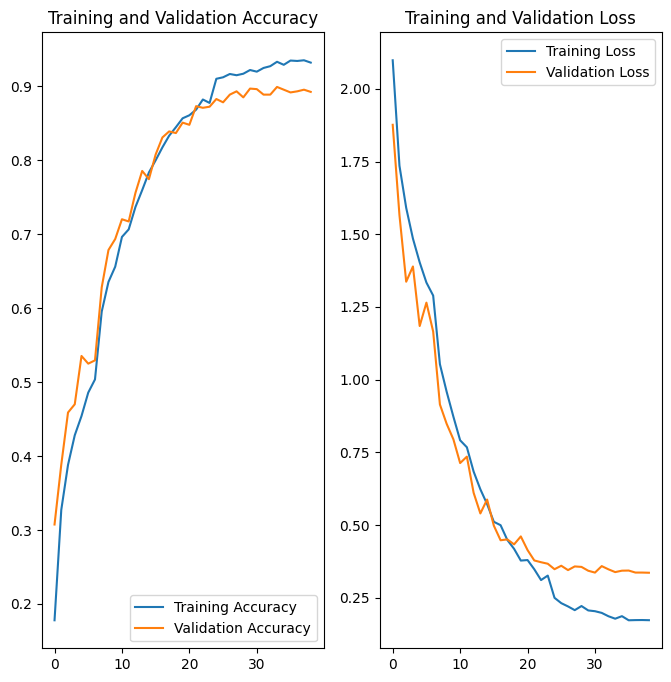

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = np.arange(early_stop_augmentor.stopped_epoch+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Interpretation***

---

1. We did not observe any stark fluctuations in either the train or validation loss, indicating that the model did not jump over local minima very often and could converge smoothly.

2. The model is good fit to the training images and performed very well over validation images as well. Validation accuracy is 90% which did not differ much with the training accuracy of 95% that was acheived at the checkpoint.

3. We can safely comment that the model hardly overfits the train set and could be utilized to produce inference on holdout set.

**Did you get rid of underfitting/overfitting? Did class rebalance help?**

---

Yes. Class rebalance prevented the algorithm from underfitting the train set (as we previously sufferred with), thus resulted into a model that fits appropriately.

In [70]:
from keras.models import load_model

if pathlib.Path('/content/model_augmentor.h5').is_file():
  # if model is available at the current runtime
  model_1 = load_model('model_augmentor.h5')
  print('INFO: Temporary stored "model_augmentor.h5" has been loaded successfully.')
  print('WARNING: Prevent losing the temporary "model_augmentor.h5" file. You must download and save the file at "gdrive/MyDrive", so it can be loaded later from this location in the event of unintended runtime disconnection !!')
elif pathlib.Path('/content/gdrive/MyDrive/model_augmentor.h5').is_file():
  # load the serialized weights from
  model_1 = load_model(pathlib.Path('/content/gdrive/MyDrive/model_augmentor.h5'))
  print('INFO: "gdrive/MyDrive/model_augmentor.h5" file has been loaded successfully.')
else:
  raise Exception('FileNotFoundError: Your last runtime was disconnected and hence the current runtime could not retrieve the previously created temporary HDF5 model file. Maybe you have missed to download/save the previously generated "model_augmentor.h5" file at your directory "/gdrive/MyDrive" to reuse it in the event of unintended runtime diconnection !!')
train_loss, train_accuracy = model_1.evaluate(train_ds, verbose=1,)
validation_loss, validation_accuracy = model_1.evaluate(val_ds, verbose=1)

print('Train Accuracy: ', train_accuracy)
print('Validation Accuracy: ',validation_accuracy)
print('Train Loss: ',train_loss)
print('Validation Loss', validation_loss)

INFO: Temporary stored "model_augmentor.h5" has been loaded successfully.
43/43 [==============================] - 5s 103ms/step - loss: 0.3381 - accuracy: 0.8990
Train Accuracy:  0.9540059566497803
Validation Accuracy:  0.8990349173545837
Train Loss:  0.11337125301361084
Validation Loss 0.33811822533607483


#### Model evaluation on test image

In [85]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

1/1 [==============================] - 0s 40ms/step
Actual Class: basal cell carcinoma
Predictive Class: basal cell carcinoma


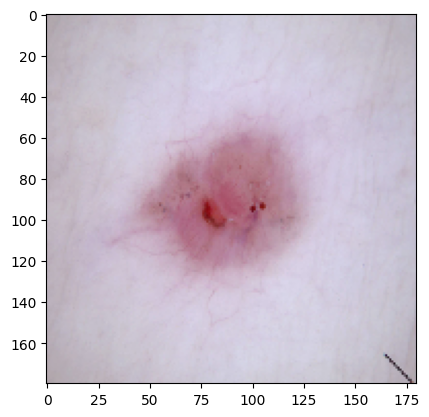

In [88]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
image_test = os.path.join(data_dir_test, class_names[1], '*')
image_test = glob(image_test)
image_test = load_img(image_test[-1],target_size=(180,180,3))
plt.imshow(image_test)
plt.grid(False)

img = np.expand_dims(image_test,axis=0)
pred = model_augmentor.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class: {class_names[1]}" + '\n' + "Predictive Class: " + pred_class)